In [1]:
import math
import numba
import numpy as np
import h5py

import jax
import jax.numpy as jax_np

# optimization and MCMC
import pyhmc
from iminuit import Minuit
import scipy.special

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

In [2]:
DEFAULT_PARAMS = np.array([
    -1.777,  # log10epsilon
    11.514,  # log10M1
    -1.412,  # alpha
    0.316,  # gamma
    3.508  # delta
])

## Autograd w/ Jax

In [3]:
@jax.jit
def _my_fun(log10mvir_peak, params):
    log10epsilon = params[0]
    log10M1 = params[1]
    alpha = params[2]
    gamma = params[3]
    delta = params[4]
    
    def _f(x):
        return (
            -jax_np.log10(jax_np.power(10.0, alpha * x) + 1) + 
            delta * 
            jax_np.power(jax_np.log10(1 + jax_np.exp(x)), gamma) / 
            (1.0 + jax_np.exp(jax_np.power(10.0, -x))))


    log10_mh_m1 = log10mvir_peak - log10M1
    return log10epsilon + log10M1 + _f(log10_mh_m1) - _f(0)

_my_fun_grad = jax.jit(jax.vmap(jax.grad(_my_fun, 1), in_axes=(0, None)))


def log10mstar_mpeak(log10mvir_peak, params, grad=False):
    """log10M*(Mvir_peak) from Behroozi et a. (2012, 1207.6105), Eq. 3.
    
    Only valid at z = 0.
    
    Parameters
    ----------
    log10mvir_peak : np.array
        The base-10 log of the peak virial mass of the subhalo.
    params : np.array
        An array of the parameters in the order 
        [log10epsilon, log10M1, alpha, gamma, delta].
    grad : bool, optional
        If True, just Jax to compute the derivatives and return as second return value.
    
    Returns
    -------
    log10mstar : np.array
        The base-10 log of the stellar mass.
    log10mstar_grad : np.array
        The derivative of the output wrt the params. Only present if `grad=True` is set.
    """
    n_params = params.shape[0]
    n_data = log10mvir_peak.shape[0]
    
    if grad:
        return _my_fun(log10mvir_peak, params)._value, _my_fun_grad(log10mvir_peak, params)._value
    else:
        return _my_fun(log10mvir_peak, params)._value

Test this to make sure it runs:

In [4]:
p, pg = log10mstar_mpeak(np.log10(np.array([1e12, 1e14])), DEFAULT_PARAMS, grad=True)
print(p, pg)

/Users/Matt/miniconda3/envs/anl-py37/lib/python3.7/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


[10.428106 11.204406] [[ 1.0000000e+00  4.4507146e-02 -8.2999207e-02 -1.9589996e-01
   1.3438046e-01]
 [ 1.0000000e+00  7.8672653e-01 -7.6760008e-04  9.7131228e-01
   3.3252856e-01]]


## Binning Function w/ Deriv

In [5]:
@numba.njit
def kernel_hist_with_derivs(log10mstar, log10mstar_jac, bins, sigma):
    """Compute a histogram of the input stellar masses along with the 
    derivatives of this histogram using the input jacobian.
    
    Parameters
    ----------
    log10mstar : np.array, shape (n_data,)
        The input stellar masses to histogram.
    log10mstar_jac : np.array, shape (n_data, n_params)
        The jacobian derivs of the input stellar masses wrt the params.
    bins : np.array, shape (n_bins+1,)
        An array of the bin edges.
    sigma : float or np.array of shape (n_data,)
        The width of the Gaussian kernel to use for the bins. Should be 
        roughly the scatter in the stellar to halo mass relation with 
        any observational errors. FIXME: We need to output a derivative 
        wrt this as well.
    
    Returns
    -------
    hist : np.array, shape (n_bins,)
        The output histogram.
    hist_jac : np.array, shape (n_bins, n_params)
        The derivatives of the histogram bins wrt the params.
    """
    n_bins = bins.shape[0]-1
    n_params = log10mstar_jac.shape[1]
    n_data = log10mstar.shape[0]
    
    hist = np.zeros(n_bins, dtype=np.float64)
    hist_jac = np.zeros((n_bins, n_params), dtype=np.float64)

    sigma_sqrt2 = sigma * math.sqrt(2)
    sigma_sqrt2pi = sigma_sqrt2 * math.sqrt(math.pi)

    for i in range(n_data):
        x = log10mstar[i]

        z = (x - bins[0]) / sigma_sqrt2
        last_cdf = (1 + math.erf(z)) / 2
        last_cdf_deriv = math.exp(-z*z) / sigma_sqrt2pi

        for j in range(n_bins):
            z = (x -  bins[j+1]) / sigma_sqrt2
            new_cdf = (1 + math.erf(z)) / 2
            new_cdf_deriv = math.exp(-z*z) / sigma_sqrt2pi

            # get the hist weight
            weight = last_cdf - new_cdf
            hist[j] += weight
            
            # do the derivs
            for k in range(n_params):
                hist_jac[j, k] += (last_cdf_deriv - new_cdf_deriv) * log10mstar_jac[i, k]

            last_cdf = new_cdf
            last_cdf_deriv = new_cdf_deriv
    
    return hist, hist_jac

Make a nice canned function for this.

In [6]:
BINS = np.linspace(9, 13, 25)
LOCS = BINS[:-1] + (BINS[1] - BINS[0])/2

def run_kernel_hist(log10mvir_peak, params):
    vals, jac = log10mstar_mpeak(
        log10mvir_peak, params, grad=True)
    h, jac_h = kernel_hist_with_derivs(
        vals, 
        jac, 
        BINS, 
        0.2)
    
    return h, jac_h

## Run on Data!

In [7]:
# alright, now lets read some real data!
with h5py.File('halos_Lb125_1024.h5', 'r') as hf:
    data = hf['halos'][:]
    
msk = np.log10(data['mpeak']) > 10.0
data = data[msk]

In [8]:
log10mstar = log10mstar_mpeak(np.log10(data['mpeak']), DEFAULT_PARAMS)

Make a plot of the data

<Figure size 432x288 with 0 Axes>

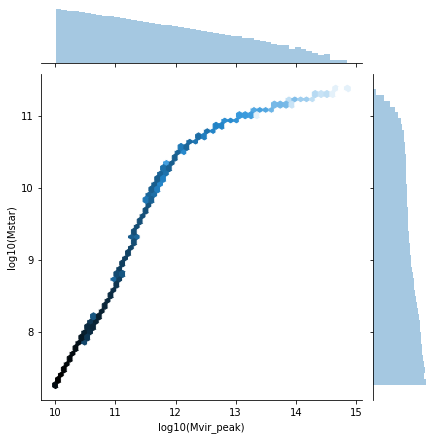

In [9]:
plt.figure()
jg = sns.jointplot(
    np.log10(data['mpeak']), 
    log10mstar, 
    kind='hex', bins='log', 
    marginal_kws={'hist_kws': {'log': True}},
    )
jg.set_axis_labels('log10(Mvir_peak)', 'log10(Mstar)')

### Now let's try using our function above

We run it once to get the jit to compile before timing.

In [10]:
h, jac_h = run_kernel_hist(np.log10(data['mpeak']), DEFAULT_PARAMS)

In [11]:
%%time

h, jac_h = run_kernel_hist(np.log10(data['mpeak']), DEFAULT_PARAMS)

CPU times: user 1.22 s, sys: 17.5 ms, total: 1.24 s
Wall time: 1.17 s


Almost all of this time is the histogram. The autodiff is really fast!

In [12]:
%%time

_ = log10mstar_mpeak(np.log10(data['mpeak']), DEFAULT_PARAMS)

CPU times: user 72.2 ms, sys: 2.33 ms, total: 74.5 ms
Wall time: 38.2 ms


Make some "observed" data.

In [13]:
n_obs = 1e3
h_meas = np.random.poisson(lam=h / data.shape[0] * n_obs)

Let's also plot the data

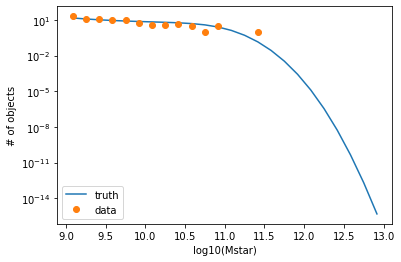

In [14]:
plt.figure()
plt.semilogy(LOCS, h/data.shape[0]*n_obs, label='truth')
msk = h_meas > 0
plt.semilogy(LOCS[msk], h_meas[msk], 'o', label='data')
plt.xlabel('log10(Mstar)')
plt.ylabel('# of objects')
plt.legend(loc=3)

Text(0, 0.5, 'dP(log10(Mstar))/dparam')

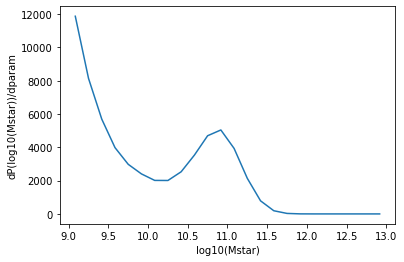

In [15]:
plt.figure()
plt.plot(LOCS, jac_h[:, 0])
plt.xlabel('log10(Mstar)')
plt.ylabel('dP(log10(Mstar))/dparam')

## And finally, let's "fit" some data via maximum likelihood and HMC

In [16]:
import scipy.special

# this should NOT a class but I am being lazy
class DataLogLike(object):
    def __init__(self, log10mvir_peak, h_meas, n_obs):
        self.h_meas = h_meas
        self.n_obs = n_obs
        self.log10mvir_peak = log10mvir_peak
        self._lnfact_h_meas = scipy.special.gammaln(h_meas + 1)

        # this is a really hacky cache system for getting the 
        # deriv from the last function call
        self._last_call = None

    def neglogprob_and_grad(self, params):
        if self._last_call is None or not np.array_equal(params, self._last_call['params']):
            h_mod, jac_h = run_kernel_hist(self.log10mvir_peak, params)
            h_mod *= (self.n_obs/self.log10mvir_peak.shape[0])
            jac_h *= (self.n_obs/self.log10mvir_peak.shape[0])
            msk = h_mod > 0

            ll = np.sum(self.h_meas[msk] * np.log(h_mod[msk]) - h_mod[msk] - self._lnfact_h_meas[msk])
            ll_jac = np.sum((self.h_meas[msk] / h_mod[msk] - 1)[:, np.newaxis] * jac_h[msk, :], axis=0)
        
            self._last_call = {}
            self._last_call['negll'] = -ll
            self._last_call['negll_jac'] = -ll_jac
            self._last_call['params'] = params.copy()
    
        # print(params, self._last_call['negll'])
        return self._last_call['negll'], self._last_call['negll_jac']

    def logprob_and_grad(self, params):
        ll, llg = self.neglogprob_and_grad(params)
        return -ll, -llg
    
    def neglogprob(self, params):
        return self.neglogprob_and_grad(params)[0]

    def grad_neglogprob(self, params):
        return self.neglogprob_and_grad(params)[1]
    
data_ll = DataLogLike(np.log10(data['mpeak']), h_meas, n_obs)

In [17]:
%%time

print(data_ll.neglogprob(DEFAULT_PARAMS))
print(data_ll.grad_neglogprob(DEFAULT_PARAMS))
print(data_ll.neglogprob_and_grad(DEFAULT_PARAMS))

31.383638018891528
[  1.54010886  -1.53132401  -7.45380715 -15.05520334   2.41534184]
(31.383638018891528, array([  1.54010886,  -1.53132401,  -7.45380715, -15.05520334,
         2.41534184]))
CPU times: user 1.15 s, sys: 12.3 ms, total: 1.16 s
Wall time: 1.08 s


Now we run minuit. See this [tutorial](https://nbviewer.jupyter.org/github/scikit-hep/iminuit/blob/master/tutorial/basic_tutorial.ipynb) for details.

In [18]:
m = Minuit.from_array_func(
    data_ll.neglogprob, 
    DEFAULT_PARAMS, 
    error=np.abs(DEFAULT_PARAMS) * 0.01, 
    errordef=0.5,
    print_level=0,
    grad=data_ll.grad_neglogprob)

m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |  -1.777   |   0.018   |            |            |         |         |       |
| 1 | x1   |   11.51   |   0.12    |            |            |         |         |       |
| 2 | x2   |  -1.412   |   0.014   |            |            |         |         |       |
| 3 | x3   | 3.160E-1  | 0.032E-1  |            |            |         |         |       |
| 4 | x4   |   3.51    |   0.04    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [19]:
m.migrad(ncall=100, nsplit=10)

------------------------------------------------------------------
| FCN = 27.59                   |      Ncalls=4 (68 total)       |
| EDM = 4.78E-07 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   -2.05   |    0.14   |            |            |         |         |       |
| 1 | x1   |   11.41   |   0.24    |            |            |         |         |       |
| 2 | x2   |   -0.7    |    0.3    |            |            |         |         |       |
| 3 | x3   |   0.60    |   0.16    |            |            |         |         |       |
| 4 | x4   |    4.7    |    1.1    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [21]:
m.hesse()
m.hesse()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   -2.05   |    0.21   |            |            |         |         |       |
| 1 | x1   |   11.41   |   0.29    |            |            |         |         |       |
| 2 | x2   |   -0.7    |    2.8    |            |            |         |         |       |
| 3 | x3   |    0.6    |    0.8    |            |            |         |         |       |
| 4 | x4   |    4.7    |    3.0    |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [22]:
m.matrix(correlation=True)

---------------------------------
|    |   x0   x1   x2   x3   x4 |
---------------------------------
| x0 |  1.0  0.9 -0.8  0.6 -0.9 |
| x1 |  0.9  1.0 -0.7  0.6 -0.8 |
| x2 | -0.8 -0.7  1.0 -1.0  1.0 |
| x3 |  0.6  0.6 -1.0  1.0 -0.9 |
| x4 | -0.9 -0.8  1.0 -0.9  1.0 |
---------------------------------

Make a plot of the model.

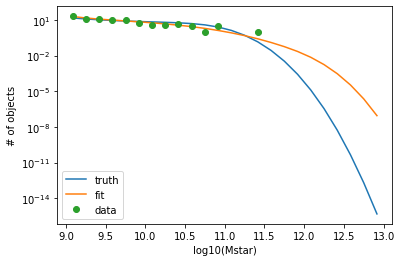

In [24]:
params = np.array(m.values.values())
h_fit, _ = run_kernel_hist(np.log10(data['mpeak']), params)

plt.figure()
plt.semilogy(LOCS, h/data.shape[0]*n_obs, label='truth')
plt.semilogy(LOCS, h_fit/data.shape[0]*n_obs, label='fit')
msk = h_meas > 0
plt.semilogy(LOCS[msk], h_meas[msk], 'o', label='data')
plt.xlabel('log10(Mstar)')
plt.ylabel('# of objects')
plt.legend(loc=3)

## Try HMC (not tuned at all, very slow)

See this [book chapter](http://www.mcmchandbook.net/HandbookChapter5.pdf) 
for an introduction to Hamiltonian Monte Carlo. I am using the [pyhmc](https://pythonhosted.org/pyhmc/index.html)
package here, but we should be using a much better algorithm like those in STAN or PYMC3.

In [ ]:
samps, samps_logp, diagn = pyhmc.hmc(
    data_ll.logprob_and_grad, 
    np.array(m.values.values()),
    n_samples=1000,
    n_steps=10,
    epsilon=0.1,
    n_burn=250,
    return_logp=True,
    return_diagnostics=True,
    display=False)

print('acc rate:', 1.0 - diagn['rej'])

In [ ]:
pyhmc.autocorr1.integrated_autocorr1(samps)

In [ ]:
plt.figure()
sns.jointplot(samps[250:, 0], samps[250:, 1])